<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science </h1>

## Case Study 2: Hunting for Flavors

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
<hr style='height:2px'>

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2020-CS109A/master/themes/static/css/cs109.css").text
HTML(styles)

In [2]:
# import the necessary libraries
import re
import requests
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
from time import sleep
from bs4 import BeautifulSoup

# global properties
data_dir = "data/" # where to save data
num_search_pages = 50 # how many search pages to cull through

# NOTE:
# if you haven't yet downloaded the data, this should be set to True
download_data = False

## Disclaimer

Alcohol is drug. There are state and federal laws that govern the sale, distribution, and consumption of such. In the United States, those who consume alcohol must be at least 21 years of age. In no way am I, or anyone else at IACS or Harvard at large, promoting or encouraging the usage of alcohol. My intention is not to celebrate it. Anyone who consumes alcohol should do so responsibly. Abusing alcohol often has serious, grave effects, ones that I've often  witnessed within my environment while growing up as a kid. I can honestly say that I was 21 years old before ever consuming alcohol; likewise, everyone who chooses to drink should be of legal drinking age. 

The point of this exercise is purely pedagogical, and it illustrates the wide range of tasks that one can apply data science and machine learning to. That is, I am focusing on a particular interest and demonstrating how it can be used to answer questions that one may be interested in for one's own personal life. You could easily imagine this being used in professional settings, too.

### Learning Objectives
Help see the big picture process of conducting a project, and to illustrate some of the nuanced details and common pitfalls.

## 1. Problem Overview 

Whiskey is a type of alcohol, and there are many different types of whiskey, including **bourbon,** which will be the focus of this project. 

I am interested in determining:

1. Are there certain attributes of bourbons that are predictive of good (i.e., highly rated by users) bourbons?
    - Find hidden gems (i.e., should be good but current reviews are absent or unsupportive of such)
	- Find over-hyped whiskeys (i.e., the reviews seem high but the attributes aren't indicative)
	- Are there significant results if we target experts' ratings instead of average customer ratings?

2. Are there certain attributes of bourbons that are predictive of expensive bourbons?
    - Find under-priced whiskeys
    - Find over-priced whiskeys

3. Which bourbons are under-/over- priced?

4. Which bourbons are more similar to each other?
    - Which attributes are important for determining similarness? (e.g., does price play a role?)

## 2. Obtaining Data

We need a website that has a bunch of whiskey data. `Distiller.com` seems to be the most authoritative and comprehensive site.

Using `distiller.com` as our source, I don't see a way to display a list of all of their bourbons. But, if you search for the keyword `bourbon`, over 2,000 search results appear, each with a link to the particular whiskey. After manual inspection, these in fact are bourbons, but a few are not and merely have some association with bourbon (e.g., non-bourbon whiskeys that were casked in old bourbon barrels).

Let's crawl the search results pages to create a set of all candidate bourbons (i.e., `whiskey_urls`)! Then, using this set, let's download each page. Note, we use a `set()` instead of a list, in case there are duplicates.

<div class='exercise'><b>Fetching list of webpages via Requests</b></div>

In [3]:
whiskey_urls = set()

if download_data:

    # we define this for convenience, as every state's url begins with this prefix
    base_url = 'https://distiller.com/search?term=bourbon'
    
    # visits each search result page
    for page_num in range(1, num_search_pages):
        cur_page = requests.get('https://distiller.com/search?page=' + str(page_num) + '&term=bourbon')

        # uses BeautifulSoup to extract all links to whiskeys
        bs_page = BeautifulSoup(cur_page.content, "html.parser")
        for link in bs_page.findAll('a', attrs={'href': re.compile("^/spirits/")}):
            whiskey_urls.add(link.get('href'))

        sleep(1)
    
    # saves each URL to disk, so that we don't have to crawl the search results again
    f = open("whiskey_urls.txt", "w")
    for url in whiskey_urls:
        f.write(url + "\n")
    f.close()
    
    # fetches each page and saves it to the hard drive
    for url in whiskey_urls:
        cur_page = requests.get('https://distiller.com' + url).content

        # writes file
        f = open(data_dir + url[9:], 'wb')
        f.write(cur_page)
        f.close()

        # sleeps between 1-3 seconds, in case the site tries to detect crawling
        sleep(random.randint(1,3))
else: 
    
    # if the files have already been saved to disk
    # then you can just load them here, instead of crawling again
    with open('whiskey_urls.txt') as f:
        whiskey_urls = set(line.strip() for line in f)

We now have a list of all whiskey urls, in `whiskey_urls`, along with the actual page downloaded to our hard drive. We downloaded them to the hard drive for convenience, so that in the future, we don't have to spend the 2 hours crawling all pages again.

Let's now load each of these pages!

In [4]:
whiskeys = {}

# loads whiskey webpage
for i, url in enumerate(whiskey_urls):

    filename = data_dir + url[9:]
    file_contents = open(filename, 'r').read()
    
    # instantiates a new BeautifulSoup object
    soup = BeautifulSoup(file_contents, "html.parser")
    
    # extracts details about the whiskey
    name = soup.find('h1', attrs={'class': re.compile("secondary-headline name")}).text.strip()
    location = soup.find('h2', attrs={'class': "ultra-mini-headline location middleweight"}).text.strip()

    soup.find('div', attrs={'class': "spirit-badge"})

    badge = ""
    if soup.find('div', attrs={'class': "spirit-badge"}) != None:
        badge = soup.find('div', attrs={'class': "spirit-badge"}).text.strip()
        
    num_ratings = 0
    rating = "N/A"
    if soup.find('span', attrs={'itemprop': "ratingCount"}) != None:
        num_ratings = int(soup.find('span', attrs={'itemprop': "ratingCount"}).text.strip())
        rating = float(soup.find('span', attrs={'itemprop': "ratingValue"}).text.strip())
    
    age = soup.find('li', attrs={'class': "detail age"}).find('div', attrs='value').text.strip()
    price = int(re.findall("cost-(\d)", str(soup.find('div', attrs={'class': re.compile("spirit-cost")})))[0])
    abv = ""
    
    if soup.find('li', attrs={'class': "detail abv"}).find('div', attrs='value').text != "":
        abv = float(soup.find('li', attrs={'class': "detail abv"}).find('div', attrs='value').text)
    
    whiskey_type = soup.find('li', attrs={'class': "detail whiskey-style"}).div.text
    cask_type = ""
    if soup.find('li', attrs={'class': "detail cask-type"}) != None:
        cask_type = soup.find('li', attrs={'class': "detail cask-type"}).find('div', attrs='value').text.strip()
    
    review = ""
    author = ""
    score = ""
    flavor_summary = ""
    flavor_profile = []
    
    # check if an expert reviewed it
    if soup.find('p', attrs={'itemprop': "reviewBody"}) != None:
        review = soup.find('p', attrs={'itemprop': "reviewBody"}).text.replace("\"","").strip()
    
        author = soup.find('div', attrs={'class': 'meet-experts'}).a.text.strip()
        score = int(soup.find('div', attrs={'class': "distiller-score"}).span.text.strip())
        flavor_summary = soup.find('h3', attrs={'class': "secondary-headline flavors middleweight"}).text.strip()
    
        # extracts flavor profile
        flavor_profile = eval(soup.find('canvas').attrs['data-flavors'])
    
    cur_whiskey = [name, whiskey_type, cask_type, location, age, abv, price, badge, num_ratings, \
        rating, flavor_summary, author, score]

    if flavor_profile:
        cur_whiskey.extend(list(flavor_profile.values()))
    else:
        cur_whiskey.extend(np.zeros(14))
        
    cur_whiskey.append(review)
    whiskeys[i] = cur_whiskey

    df = pd.DataFrame.from_dict(whiskeys, orient='index', \
        columns=['Name', 'Type', 'Cask', 'Location', 'Age', 'ABV %', 'Price', 'Badge',\
                 '# Ratings', "Customers' Rating", 'Flavor Summary', 'Author', 'Author Score',\
                 'Smoky', 'Peaty', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',\
                 'Sweet', 'Briny', 'Salty', 'Vanilla', 'Tart', 'Fruity', 'Floral', 'Review'])

## 3. Data Sanity Check / Cleaning

What do our features look like? Are any features wonky, inconsistent, useless, or missing values?

<div class='exercise'><b>Let's use only the whiskeys that have been reviewed by experts</b>
</div>

In [5]:
pd.set_option('display.max_columns', None)
df2 = df.loc[(df['Author'] != "")]
print(len(df2))

710


In [6]:
df2['Type'].value_counts()

Bourbon                          586
Single Malt                       27
Blended American Whiskey          14
Aged Rum                          12
Other Whiskey                     11
Peated Single Malt                11
Flavored Whiskey                   5
Rhum Agricole Vieux                4
Gold Rum                           4
Tequila Reposado                   4
American Single Malt               3
Blended                            3
Spiced Rum                         3
Tequila Añejo                      3
Canadian                           2
Cachaça                            2
Barrel-Aged Gin                    2
Rye                                2
Flavored Rum                       2
Dark Rum                           2
Silver Rum                         1
Other Brandy                       1
Other Liqueurs                     1
Old Tom Gin                        1
Rhum Agricole Éléve Sous Bois      1
Rhum Agricole Blanc                1
White                              1
D

<div class='exercise'><b>Let's only use the bourbons.</b> We have 586 bourbons, which is my primary focus. This isn't tons, but the non-bourbons will likely add noise, as they are different alcohols.
</div>

In [7]:
pd.set_option('display.max_rows', None)
df2 = df2.loc[(df['Type'] == "Bourbon")]

<div class='exercise'><b>Let's inspect the data types</b>
</div>

In [8]:
df2.dtypes

Name                  object
Type                  object
Cask                  object
Location              object
Age                   object
ABV %                 object
Price                  int64
Badge                 object
# Ratings              int64
Customers' Rating     object
Flavor Summary        object
Author                object
Author Score          object
Smoky                float64
Peaty                float64
Spicy                float64
Herbal               float64
Oily                 float64
Full-bodied          float64
Rich                 float64
Sweet                float64
Briny                float64
Salty                float64
Vanilla              float64
Tart                 float64
Fruity               float64
Floral               float64
Review                object
dtype: object

<div class='exercise'><b>"Customers' Rating"</b> feature should be a Float. Let's fix it.
</div>

In [9]:
df2.loc[df2['Customers\' Rating'] == "N/A"]

,Name,Type,Cask,Location,Age,ABV %,Price,Badge,# Ratings,Customers' Rating,Flavor Summary,Author,Author Score,Smoky,Peaty,Spicy,Herbal,Oily,Full-bodied,Rich,Sweet,Briny,Salty,Vanilla,Tart,Fruity,Floral,Review
922,Tacoma New West Bourbon,Bourbon,"new, charred American oak","Heritage Distilling Co. // Washington, USA",NAS,46,2,,0,N/A,Vanilla & Sweet,Brock Schulte,78,0.0,0.0,30.0,40.0,0.0,40.0,30.0,80.0,20.0,20.0,100.0,30.0,60.0,50.0,"Nose is full of sweet corn, fresh caramel, and..."


In [10]:
# there still exists 1 whiskey that has no Customer Rating, so let's remove it
df2 = df2.loc[df2['Customers\' Rating'] != "N/A"]
df2 = df2.astype({'Customers\' Rating' : 'float64'})

<div class='exercise'><b>"Age"</b> feature should represent years. Let's fix it.
</div>

In [11]:
# we can keep the 'Age' feature for now but be mindful
# that it's missing for nearly half of the whiskeys
len(df2.loc[(df2['Age'] == 'NAS') | (df2['Age'] == 'nas') | (df2['Age'] == '')])

378

In [12]:
# let's replace all missing values with a reasonable value.
# for now, let's use 0 as a placeholder so that we can later swap it out.
df2['Age'] = df2['Age'].replace(['NAS', 'nas', 'N/A',''],'0')

In [13]:
# remove the 'Years' part of the text
df2['Age'].replace(to_replace =' [yY]ear[sS]*', value = '', regex = True) 

1                     0
2                     0
4                     0
6                     0
9                     0
11                   12
12                    0
13                   12
25                    0
29                    0
33                   12
37                    0
50                    0
51                    0
54                    0
59                    9
65                    0
76                    0
77                   12
94                   13
97                    0
101                   0
104                  12
113                   0
116                   0
118                  12
120                   0
123                   0
124                   0
132                   0
133                   0
139                  12
140                   0
141                   0
142                   0
145                   0
148                  21
152                   0
155                   9
156                   0
163                   0
167             

In [14]:
# manually cleaning up values that otherwise would be a bit impossible to automatically clean-up
df2['Age'] = df2['Age'].replace(to_replace ='6.*', value = '6', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='(\d+) [Yy].*', value = '\\1', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='4 [Mm]onths', value = '4', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='9 [Mm]onths', value = '9', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='18 - 20 [Mm]onths', value = '1.5', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='32 [Mm]onths', value = '2.67', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='9 [Mm]onths', value = '9', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='9 to 11', value = '0.75', regex = True)

In [15]:
# let's look at all of the items that had an Age statement listed
# (now that all values have been cleaned-up)
df2.loc[df2['Age'] > '0']['Age']

11        12
13        12
33        12
59         9
77        12
94        13
104       12
118       12
139       12
148       21
155        9
169        6
170       15
178       12
197        6
205        3
210        6
213       12
214        6
215        7
236       10
237       12
241       11
252        8
259       10
262        6
265        4
268       11
288        8
314       10
320       10
337       22
344      7.2
353       12
355        4
358       12
364        6
367       27
368        6
377       20
380        9
424        6
439        8
444       12
447       20
464       10
472       20
475       23
485       10
499       13
504       12
509       12
513        6
518       16
523       12
531       15
541       12
551       13
569       11
580       17
590        6
612       24
613       11
645       22
657       26
691        6
697        3
706       20
724        3
728       14
732        4
742       12
743        7
761        8
769       23
773        9
775        9

In [19]:
df2 = df2.astype({'Age': 'float64'})

In [20]:
# how many had values?
len(df2.loc[df2['Age'] > 0])

206

In [21]:
df2['Age'].describe()

count    585.000000
mean       3.776274
std        6.010627
min        0.000000
25%        0.000000
50%        0.000000
75%        7.000000
max       28.000000
Name: Age, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d4359d0>]],
      dtype=object)

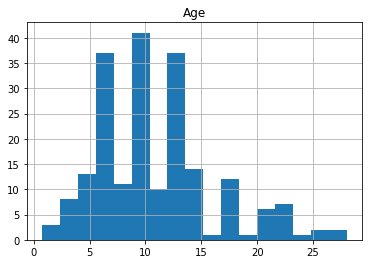

In [22]:
df2.loc[df2['Age'] > 0].hist(column='Age', bins='auto')

I think it's fair to impute all missing values (i.e., 0) with 7. This is based on research, too (Googling and personal knowledge)

In [23]:
df2['Age'] = df2['Age'].replace(0,7)

In [24]:
df2['Age'].describe()

count    585.000000
mean       8.311316
std        3.607727
min        0.750000
25%        7.000000
50%        7.000000
75%        7.000000
max       28.000000
Name: Age, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cd87910>]],
      dtype=object)

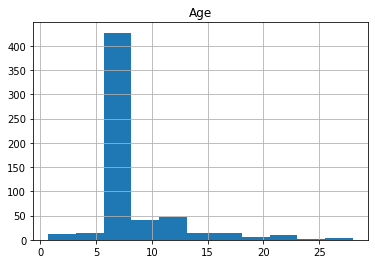

In [25]:
df2.hist(column='Age', bins='auto')

<div class='exercise'>What's the distribution of the <b>"Flavor Summary"</b> feature? Is it consistent enough to use?
</div>

In [26]:
df2['Flavor Summary'].value_counts()

Rich & Full Bodied       54
Sweet & Rich             40
Sweet                    36
Vanilla & Sweet          34
Spicy                    33
Vanilla & Rich           24
Full Bodied & Rich       20
Sweet & Vanilla          20
Vanilla                  18
Spicy & Rich             18
Vanilla & Full Bodied    17
Fruity & Sweet           17
Full Bodied & Spicy      17
Spicy & Vanilla          16
Rich & Spicy             13
Sweet & Spicy            13
Rich & Vanilla           13
Vanilla & Spicy          11
Full Bodied              11
Spicy & Full Bodied      10
Full Bodied & Vanilla    10
Spicy & Sweet            10
Fruity                    9
Rich & Sweet              9
Sweet & Full Bodied       9
Rich                      9
Sweet & Fruity            8
Spicy & Fruity            7
Fruity & Rich             7
Fruity & Spicy            5
Spicy & Smoky             5
Fruity & Vanilla          4
Spicy & Herbal            3
Floral                    3
Floral & Fruity           3
Sweet & Herbal      

Ok, there's a long tail of values, and it seems the Flavors are just the two most prominent flavors listed for each whiskey, although some only list one flavor. Perhaps this offers no additional information/signal than using the raw values of the flavors. Although, it might be worth experimenting with this by turning this feature into 2 new features: primary flavor, secondary flavor. These would need to be one-hot encoded though, and since there are 14 distinct flavors, that would create 28 new features (or 26). Again, these 26 features might be redundant and not help our models.

<div class='exercise'>What is the <b>"Badge"</b> feature like?

In [27]:
df2['Badge'].value_counts()

                                            428
RARE                                        119
Requested By\nElw00t                          2
Requested By\nAJLovesWhiskey                  1
Requested By\nCblake34                        1
Requested By\nBourbonPizon                    1
Requested By\ntjbriley                        1
Requested By\nstevenblackburn7                1
Requested By\nJacob-Haralson                  1
Requested By\njimcorwin3                      1
Requested By\nbodkins                         1
Requested By\ncubfancccc                      1
Requested By\ndanmeister33                    1
Requested By\nJamesSpears                     1
Requested By\nspectorjuan                     1
Requested By\nTmoore8601                      1
Requested By\nandrewls24                      1
Requested By\nsamueljcarlson                  1
Requested By\njd139                           1
Requested By\ncpreynolds87                    1
Requested By\nEast17                    

We see that all Badge values are either 'RARE' or just requests from users for an expert to review it. So, let's change the badge column to being a 'Rare' column.

In [28]:
df2['Rare'] = [True if x == 'RARE' else False for x in df2['Badge']] #df['Badge'] #.map({"RARE": True})
del df2['Badge']
df2['Rare'].value_counts()

False    466
True     119
Name: Rare, dtype: int64

<div class='exercise'>What is the <b>"Author"</b> feature like?

In [29]:
df2['Author'].value_counts()

Jacob Grier          92
Jake Emen            85
Amanda Schuster      76
Stephanie Moreno     66
Rob Morton           62
Keith Allison        26
Colin Howard         23
Sam Davies           21
Nicole Gilbert       17
Distiller Staff      15
Brock Schulte        14
Paul Belbusti        13
Ryan Conklin         12
Jack Robertiello     10
Tim Knittel          10
Katrina Niemisto      8
Ron Bechtol           4
Blair Phillips        4
Dennis Gobis          4
Thijs Klaverstijn     3
Matthew Sheinberg     3
Jason Albaum          3
Liza Weisstuch        2
Derek Gamlin          2
Lucas Gamlin          2
Michael J. Neff       2
Phil Olson            2
Brad Japhe            1
Perri Salka           1
Eric Abert            1
Anna Archibald        1
Name: Author, dtype: int64

Let's cast our features to the correct data types and view summary statistics

In [30]:
df2 = df2.astype({'Author Score': 'int32', 'Customers\' Rating' : 'float64', 'ABV %': 'float64'})

In [31]:
df2.describe()

,Age,ABV %,Price,# Ratings,Customers' Rating,Author Score,Smoky,Peaty,Spicy,Herbal,Oily,Full-bodied,Rich,Sweet,Briny,Salty,Vanilla,Tart,Fruity,Floral
count,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000
mean,8.311316,49.899838,2.803419,416.352137,3.756325,86.447863,21.485470,0.230769,53.726496,25.714530,30.695726,58.447863,57.798291,58.381197,4.018803,5.476923,50.340171,21.548718,37.066667,17.835897
std,3.607727,7.170325,1.055314,1097.906235,0.521737,5.737503,18.322834,2.187232,19.560069,19.547419,22.712536,18.317344,18.361300,16.824334,8.589855,9.603433,20.526266,17.517548,21.334758,20.336899
min,0.750000,40.000000,1.000000,1.000000,1.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,45.000000,2.000000,22.000000,3.460000,83.000000,10.000000,0.000000,40.000000,10.000000,10.000000,45.000000,45.000000,50.000000,0.000000,0.000000,35.000000,10.000000,20.000000,0.000000
50%,7.000000,47.500000,3.000000,83.000000,3.780000,87.000000,20.000000,0.000000,55.000000,25.000000,30.000000,60.000000,60.000000,60.000000,0.000000,0.000000,50.000000,20.000000,35.000000,10.000000
75%,7.000000,53.500000,4.000000,238.000000,4.170000,91.000000,30.000000,0.000000,70.000000,40.000000,45.000000,70.000000,70.000000,70.000000,5.000000,10.000000,70.000000,30.000000,50.000000,30.000000
max,28.000000,72.050000,5.000000,9072.000000,4.880000,98.000000,90.000000,40.000000,100.000000,90.000000,100.000000,100.000000,100.000000,99.000000,80.000000,80.000000,100.000000,75.000000,100.000000,95.000000


## 4. EDA
Now that our data is cleaned, let's explore it and try to understand any patterns. This understanding will impact our modelling choices. Based on the `.describe()` statistics above, let's first look at the most extreme values of features that seem a bit lopsided in their distribution of values.

<div class='exercise'>Which are the most <b>"Smoky"</b>? Intent is to see if there are any errors or something worth noting.

In [32]:
df2.sort_values(by=['Smoky'], ascending=False)[0:15][['Name', 'Smoky', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Smoky,ABV %,Price,Customers' Rating,Author Score
331,Cleveland Bourbon,90.0,50.00,2,2.48,70
1397,"Booker's Bourbon Batch 2019-04 ""Beaten Biscuits""",80.0,63.05,3,4.21,87
372,Jim Beam Black Label Extra-Aged,80.0,43.00,1,3.28,84
769,Pappy Van Winkle 23 Year,80.0,47.80,5,4.54,89
1420,Warbringer Mesquite Smoked Southwest Bourbon,80.0,49.00,3,4.16,85
789,Rebel Yell Kentucky Straight Bourbon 100 Proof,75.0,50.00,1,3.46,86
1983,Booker's 25th Anniversary Bourbon,75.0,65.40,4,4.45,96
572,Jim Beam Double Oak,75.0,43.00,2,3.21,82
345,Elk Rider Bourbon,70.0,46.00,2,3.02,79
1474,Elijah Craig Barrel Proof Bourbon,70.0,68.50,4,4.33,93


<div class='exercise'>Which are the most <b>"Peaty"</b>? Intent is to see if there are any errors or something worth noting.

In [33]:
df2.sort_values(by=['Peaty'], ascending=False)[0:10][['Name', 'Peaty', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Peaty,ABV %,Price,Customers' Rating,Author Score
29,New Riff Backsetter Peated Backset Bourbon,40.0,50.0,2,3.06,84
1022,Backbone Prime Blended Bourbon,20.0,52.0,2,3.61,82
762,J. Riddle Peated Bourbon,15.0,45.5,2,3.35,87
1420,Warbringer Mesquite Smoked Southwest Bourbon,15.0,49.0,3,4.16,85
1841,Old Bardstown Black Label Kentucky Straight Bo...,10.0,45.0,1,2.90,86
1813,Evan Williams Single Barrel,10.0,43.3,2,3.87,96
659,Knob Creek Small Batch Bourbon,10.0,50.0,2,3.47,84
2008,Angel's Envy Bourbon Finished in Port Wine Bar...,5.0,62.0,5,4.26,92
353,Lux Row Distillers Double Barrel Bourbon 12 Year,5.0,59.2,4,4.03,91
2,Still & Oak Straight Bourbon,5.0,43.0,2,3.40,83


<div class='exercise'>Which are the least <b>"Spicy"</b>? Intent is to see if there are any errors or something worth noting.

In [34]:
df2.sort_values(by=['Spicy'], ascending=True)[0:14][['Name', 'Spicy', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Spicy,ABV %,Price,Customers' Rating,Author Score
1225,Rebel Yell Kentucky Straight Bourbon,0.0,40.00,1,2.88,84
332,Dancing Pines Bourbon,0.0,44.00,2,3.09,82
735,Three Chord Blended Bourbon,10.0,40.50,2,3.10,72
1409,Old Charter 8 Year,10.0,40.00,1,2.88,80
1954,Burnside Oregon Oaked Bourbon,10.0,48.00,2,3.43,84
307,County Seat Spirits Hidden Copper Bourbon,15.0,45.00,2,3.50,80
2052,TX Straight Bourbon Whiskey,15.0,47.00,4,3.47,84
1984,Orange County Distillery Bourbon,15.0,45.00,3,3.38,79
518,Black Maple Hill 16 Year Bourbon,15.0,47.50,4,4.62,97
590,Wild Turkey Rare Breed,15.0,54.10,2,3.84,92


<div class='exercise'>Which are the most <b>"Herbal"</b>? Intent is to see if there are any errors or something worth noting.

In [35]:
df2.sort_values(by=['Herbal'], ascending=False)[0:20][['Name', 'Herbal', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Herbal,ABV %,Price,Customers' Rating,Author Score
1693,Remus Volstead Reserve 14 Year Bottled in Bond...,90.0,50.0,5,4.25,89
1316,Temperance Trader Chinato Barrel-Finished Bourbon,90.0,45.0,2,3.61,87
25,Redemption High Rye Bourbon,82.0,46.0,2,3.35,82
591,Treaty Oak Red Handed Bourbon (Kentucky & Virg...,80.0,47.5,2,3.68,83
1191,Belle Meade Cask Strength Single Barrel Bourbo...,80.0,61.2,3,4.37,95
541,Elijah Craig Barrel Proof Bourbon Batch C919,80.0,68.4,3,4.33,91
1783,Cody Road Bourbon,78.0,45.0,2,2.72,71
340,Evan Williams White Label Bottled in Bond Bourbon,76.0,50.0,1,3.35,80
386,Black Button Four Grain Bourbon,75.0,42.0,2,3.31,87
773,Yellowstone Kentucky Straight Bourbon 9 Year (...,75.0,50.5,4,4.08,88


<div class='exercise'>Which are the most <b>"Oily"</b>? Intent is to see if there are any errors or something worth noting.

In [36]:
df2.sort_values(by=['Oily'], ascending=False)[0:15][['Name', 'Oily', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Oily,ABV %,Price,Customers' Rating,Author Score
769,Pappy Van Winkle 23 Year,100.0,47.80,5,4.54,89
1474,Elijah Craig Barrel Proof Bourbon,100.0,68.50,4,4.33,93
773,Yellowstone Kentucky Straight Bourbon 9 Year (...,95.0,50.50,4,4.08,88
591,Treaty Oak Red Handed Bourbon (Kentucky & Virg...,90.0,47.50,2,3.68,83
2131,Parker's Heritage Cognac Barrel Finish 10 Year...,90.0,50.00,3,4.53,96
541,Elijah Craig Barrel Proof Bourbon Batch C919,90.0,68.40,3,4.33,91
2041,George T. Stagg Bourbon (Fall 2013),90.0,64.10,5,4.62,97
1230,Barrell Bourbon Batch 008,85.0,66.40,4,4.20,83
1397,"Booker's Bourbon Batch 2019-04 ""Beaten Biscuits""",80.0,63.05,3,4.21,87
1652,"Colonel E.H. Taylor, Jr. Small Batch Bottled i...",80.0,50.00,2,4.14,90


<div class='exercise'>Which are the least <b>"Full-bodied"</b>? Intent is to see if there are any errors or something worth noting.

In [37]:
df2.sort_values(by=['Full-bodied'], ascending=True)[0:20][['Name', 'Full-bodied', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Full-bodied,ABV %,Price,Customers' Rating,Author Score
735,Three Chord Blended Bourbon,5.0,40.50,2,3.10,72
332,Dancing Pines Bourbon,10.0,44.00,2,3.09,82
331,Cleveland Bourbon,10.0,50.00,2,2.48,70
920,291 Colorado Bourbon,15.0,50.00,3,3.60,78
2106,Feisty Spirits Blue Corn Bourbon,15.0,44.00,2,2.50,81
896,Bird Dog Small Batch Bourbon,15.0,43.00,2,3.14,82
1063,Missouri Spirits Bourbon Whiskey,20.0,40.00,2,3.32,72
664,Barrell Bourbon New Year 2019,20.0,56.05,4,3.97,77
1313,Burnside Bourbon,20.0,48.00,2,3.14,79
1923,Central Standard Bourbon,20.0,45.00,2,2.42,80


<div class='exercise'>Which are the most <b>"Briny"</b>? Intent is to see if there are any errors or something worth noting.

In [38]:
df2.sort_values(by=['Briny'], ascending=False)[0:20][['Name', 'Briny', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Briny,ABV %,Price,Customers' Rating,Author Score
921,Treaty Oak Ghost Hill Texas Bourbon,80.0,47.50,2,3.50,80
504,Elijah Craig 12 Year,60.0,47.00,2,3.80,93
566,Jefferson's Ocean Aged at Sea Voyage 15 Specia...,50.0,45.00,4,3.87,82
405,Old Soul Blended Straight Bourbon,45.0,45.00,2,3.49,74
1783,Cody Road Bourbon,40.0,45.00,2,2.72,71
1225,Rebel Yell Kentucky Straight Bourbon,40.0,40.00,1,2.88,84
170,Pappy Van Winkle Family Reserve 15 Year,40.0,53.50,4,4.53,89
2018,Murray Hill Club Blended Bourbon,40.0,51.00,4,3.49,82
447,Pappy Van Winkle 20 Year,30.0,45.20,4,4.67,92
769,Pappy Van Winkle 23 Year,30.0,47.80,5,4.54,89


<div class='exercise'>Which are the most <b>"Salty"</b>? Intent is to see if there are any errors or something worth noting.

In [39]:
df2.sort_values(by=['Salty'], ascending=False)[0:20][['Name', 'Salty', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Salty,ABV %,Price,Customers' Rating,Author Score
921,Treaty Oak Ghost Hill Texas Bourbon,80.0,47.50,2,3.50,80
1756,Blaum Bros. Galena Reserve (Series 0),55.0,57.80,3,4.50,86
1356,Remus Repeal Reserve Series III Straight Bourbon,55.0,50.00,4,3.88,86
566,Jefferson's Ocean Aged at Sea Voyage 15 Specia...,50.0,45.00,4,3.87,82
504,Elijah Craig 12 Year,50.0,47.00,2,3.80,93
1164,Coppersea Excelsior Bourbon,40.0,48.00,4,2.88,81
789,Rebel Yell Kentucky Straight Bourbon 100 Proof,40.0,50.00,1,3.46,86
659,Knob Creek Small Batch Bourbon,40.0,50.00,2,3.47,84
262,"Booker's Bourbon Batch 2020-01 ""Granny's Batch""",40.0,63.20,4,4.07,92
170,Pappy Van Winkle Family Reserve 15 Year,40.0,53.50,4,4.53,89


<div class='exercise'>Which are the most <b>"Tart"</b>? Intent is to see if there are any errors or something worth noting.

In [40]:
df2.sort_values(by=['Tart'], ascending=False)[0:20][['Name', 'Tart', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Tart,ABV %,Price,Customers' Rating,Author Score
1693,Remus Volstead Reserve 14 Year Bottled in Bond...,75.0,50.00,5,4.25,89
97,Redemption Temptation Bourbon,74.0,41.00,2,2.91,77
340,Evan Williams White Label Bottled in Bond Bourbon,72.0,50.00,1,3.35,80
721,Peach Street Colorado Straight Bourbon,70.0,46.00,3,3.59,83
921,Treaty Oak Ghost Hill Texas Bourbon,70.0,47.50,2,3.50,80
1158,Johnny Drum Green Label Bourbon,70.0,40.00,2,3.19,82
148,Elijah Craig Single Barrel 21 Year,69.0,45.00,5,4.14,87
141,Rock Hill Farms Bourbon,68.0,50.00,3,4.19,91
591,Treaty Oak Red Handed Bourbon (Kentucky & Virg...,65.0,47.50,2,3.68,83
25,Redemption High Rye Bourbon,65.0,46.00,2,3.35,82


<div class='exercise'>Which are the most <b>"Fruity"</b>? Intent is to see if there are any errors or something worth noting.

In [41]:
df2.sort_values(by=['Fruity'], ascending=False)[0:20][['Name', 'Fruity', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Fruity,ABV %,Price,Customers' Rating,Author Score
1065,Heaven Hill Select Stock Bourbon,100.0,65.10,4,4.09,84
1406,1792 High Rye Bourbon,90.0,47.15,2,3.72,85
670,Four Roses Limited Edition Small Batch Bourbon...,90.0,53.65,4,4.28,92
314,Buffalo Trace Experimental Collection French O...,90.0,45.00,4,3.35,88
893,W.H. Harrison Governor's Reserve Bourbon,90.0,56.50,3,3.36,84
908,Parker's Heritage Master Distiller's Blend of ...,90.0,63.50,3,4.18,93
860,Barrell Bourbon Batch 007,90.0,61.20,3,3.50,83
1689,Woodford Reserve Master’s Collection Brandy Ca...,85.0,45.20,4,4.17,91
2009,Blaum Bros Knotter Bourbon 3 Year (Batch #6),85.0,45.00,2,3.49,76
340,Evan Williams White Label Bottled in Bond Bourbon,81.0,50.00,1,3.35,80


<div class='exercise'>Which are the <b>oldest?</b> Intent is to see if there are any errors or something worth noting.

In [42]:
df2.sort_values(by=['Age'], ascending=False)[0:20][['Name', 'Age', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,Age,ABV %,Price,Customers' Rating,Author Score
1842,Hirsch Selection 28 Year Bourbon,28.0,43.40,5,3.89,97
367,Heaven Hill 27 Year Barrel Proof Kentucky Stra...,27.0,47.35,5,4.26,93
657,Old Blowhard 26 Year Bourbon,26.0,45.35,5,3.68,81
2030,Michter's 25 Year Single Barrel Bourbon,25.0,54.30,5,4.49,87
612,Rhetoric 24 Year Bourbon,24.0,45.40,4,4.21,89
785,Evan Williams 23 Year Bourbon,23.0,53.50,5,4.37,86
475,Rhetoric 23 Year Bourbon,23.0,45.30,4,4.21,85
1816,Elijah Craig 23 Year Bourbon,23.0,45.00,5,4.19,90
769,Pappy Van Winkle 23 Year,23.0,47.80,5,4.54,89
645,Rhetoric 22 Year Bourbon,22.0,45.00,4,4.29,87


<div class='exercise'>Which are the most <b>popular</b>? Intent is to see if there are any errors or something worth noting.

In [43]:
df2.sort_values(by=['# Ratings'], ascending=False)[0:20][['Name', '# Ratings', 'Rare', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,# Ratings,Rare,ABV %,Price,Customers' Rating,Author Score
2073,Blanton's Original Single Barrel,9072,False,46.5,2,4.30,89
628,Buffalo Trace Bourbon,8913,False,45.0,2,3.66,83
2019,Eagle Rare 10 Year Bourbon,8656,False,45.0,2,4.02,91
243,Maker's Mark Bourbon,7209,False,45.0,2,3.46,87
1518,Woodford Reserve Bourbon,7087,False,45.2,2,3.65,85
233,Bulleit Bourbon,6712,False,45.0,2,3.48,86
2087,Four Roses Single Barrel Bourbon,5890,False,50.0,2,4.00,90
608,Basil Hayden's Bourbon,5328,False,40.0,2,3.62,80
989,Weller Special Reserve,4931,False,45.0,2,3.89,91
686,Angel's Envy Bourbon Finished in Port Wine Bar...,4741,False,43.3,2,3.86,84


Ah, interestingly, the single-most popular, `Blanton's` is actually **very** hard to find these days. The field wrongly states it's not rare, but it is essentially impossible to find in most US States, and bottles are commonly marked up from $40 MSRP to $200. I'm very surprised that this has the most reviews, but I suspect it's because it has the highest allure amongst the rare ones that are somewhat possible to find. Years ago, it was very easy to find, so maybe some reviews were from this time.

Additionally, `Weller Special Reserve` is also impossible to get within most places in the US, for most times of the year, but it has TONS of allure and attention. People obsess over it. `Weller Antique 107` is even rarer. The rest are very common within stores and bars, so the data makes sense for these.

<div class='exercise'>Which are the best according to <b>customers</b>? Intent is to see if there are any errors or something worth noting.

In [44]:
df2.sort_values(by=["Customers\' Rating"], ascending=False)[0:20][['Name', '# Ratings', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,# Ratings,ABV %,Price,Customers' Rating,Author Score
1905,Parker's Heritage Heavy Char Bourbon 10 Year,2,60.00,4,4.88,92
1721,Abraham Bowman Sweet XVI Bourbon,15,58.00,3,4.84,93
1145,William Larue Weller Bourbon (Fall 2020),1,67.25,4,4.75,93
574,William Larue Weller Bourbon (Fall 2017),182,64.10,4,4.71,90
11,William Larue Weller Bourbon (Fall 2016),134,67.70,4,4.71,96
913,William Larue Weller Bourbon (Fall 2015),232,67.30,3,4.70,98
1365,King of Kentucky 15 Year Kentucky Straight Bou...,23,65.50,5,4.69,90
761,Old Forester President's Choice Bourbon,3,59.30,5,4.67,90
1351,Four Roses Limited Edition 50th Anniversary Sm...,158,54.30,4,4.67,94
447,Pappy Van Winkle 20 Year,893,45.20,4,4.67,92


This seems correct to me, not because I've tasted any of these, but because these are famous and are highly coveted. I've never heard of the best rated, `Parker's`, though. I'd be suspicious that it's an outlier and wrong, especially considering it only has 2 reviews from users; however, the expert also gave it a high score, so it seems like a valid entry.

In [45]:
df2.sort_values(by=["Customers\' Rating"], ascending=True)[0:20][['Name', '# Ratings', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,# Ratings,ABV %,Price,Customers' Rating,Author Score
232,Double Diamond Limited Edition Bourbon 267,1,40.0,2,1.00,80
1720,Maryland Club Straight Bourbon,2,47.5,2,2.00,78
54,Syntax Spirits Bourbon,2,47.5,2,2.00,80
1361,"Winchester ""Extra Smooth"" Bourbon",75,45.0,1,2.21,65
9,Detroit City Two-Faced Bourbon,8,47.0,2,2.25,77
265,Black Button Little Barrel Bourbon,8,42.0,3,2.38,75
1922,Adirondack 601 Bourbon,21,43.2,3,2.40,78
1229,Old Crow Kentucky Straight Bourbon,197,40.0,1,2.40,71
1923,Central Standard Bourbon,9,45.0,2,2.42,80
1419,Evan Williams Green Label,177,40.0,1,2.45,81


I've never heard of any of these, so this list seems reasonable. Plus, the experts gave them all horrible reviews, so I don't suspect anything suspicious is going on (e.g., customers ironically rating a controversial, highly-appraised whiskey as being horribly low, as if to troll the ratings).

<div class='exercise'>Which are the best according to <b>experts</b>? Intent is to see if there are any errors or something worth noting.

In [46]:
df2.sort_values(by=['Author Score'], ascending=False)[0:20][['Name', '# Ratings', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,# Ratings,ABV %,Price,Customers' Rating,Author Score
808,"Booker's Bourbon Batch 2015-01 ""Big Man, Small...",698,64.35,3,4.38,98
1033,Parker's Heritage Promise of Hope,224,48.00,4,4.45,98
1677,George T. Stagg Bourbon (Fall 2019),395,58.45,4,4.59,98
913,William Larue Weller Bourbon (Fall 2015),232,67.30,3,4.70,98
499,Four Roses Limited Edition Single Barrel Bourb...,158,59.80,5,4.23,98
268,Four Roses Limited Edition Single Barrel Bourb...,503,54.20,4,4.25,98
1842,Hirsch Selection 28 Year Bourbon,11,43.40,5,3.89,97
2041,George T. Stagg Bourbon (Fall 2013),422,64.10,5,4.62,97
2163,Wild Turkey Diamond Anniversary Bourbon,278,45.50,4,4.33,97
518,Black Maple Hill 16 Year Bourbon,69,47.50,4,4.62,97


This seems right. Never heard of `Hirsch` or `Parker's` but the others are speciality versions of famous/popular whiskeys, so this makes sense.

<div class='exercise'>Which are the most <b>expensive</b>? Intent is to see if there are any errors or something worth noting.

In [47]:
df2.sort_values(by=['Price'], ascending=False)[0:15][['Name', '# Ratings', 'ABV %', 'Price', 'Customers\' Rating', 'Author Score']]

,Name,# Ratings,ABV %,Price,Customers' Rating,Author Score
923,Russell's Reserve 1998,19,51.10,5,4.64,92
270,Angel's Envy Bourbon Finished in Tawny Port Wi...,62,55.80,5,4.21,92
1965,Angel's Envy Bourbon Finished in Port Wine Bar...,105,61.20,5,4.09,93
148,Elijah Craig Single Barrel 21 Year,58,45.00,5,4.14,87
1365,King of Kentucky 15 Year Kentucky Straight Bou...,23,65.50,5,4.69,90
1048,Four Roses Limited Edition Small Batch Bourbon...,207,54.30,5,4.42,96
1336,Garrison Brothers Cowboy Bourbon Barrel Proof ...,39,66.95,5,4.34,92
508,Angel's Envy Bourbon Finished in Mizunara Oak,3,48.90,5,3.58,91
499,Four Roses Limited Edition Single Barrel Bourb...,158,59.80,5,4.23,98
485,Chicken Cock 10 Year Double Barrel Bourbon,15,52.00,5,4.24,90


We don't have high granularity (prices are just 1-5), which is perhaps a blessing in disguise -- most bourbons are \\$30 - \\$50, but some rare ones, especially due to price gouging, can be \\$100 - \\$3,000. That's a wild range and is largely due to rarity, allure, and sensationalism within human behavior, as opposed to actual qualities of the bourbon. So, maybe it's good that we don't have to deal with outlier whiskeys have extraordinary prices.

<div class='exercise'>Where do they come from? Intent is to see if there are any errors or something worth noting.

In [48]:
df2['Location'].value_counts()

Booker's // Kentucky, USA                                                                 22
Four Roses // Kentucky, USA                                                               18
Buffalo Trace // Kentucky, USA                                                            16
Old Forester // Kentucky, USA                                                             16
Jim Beam // Kentucky, USA                                                                 15
Heaven Hill // Kentucky, USA                                                              14
Elijah Craig // Kentucky, USA                                                             13
Woodford Reserve // Kentucky, USA                                                         12
Wild Turkey // Kentucky, USA                                                              10
Michter's // Kentucky, USA                                                                 7
Knob Creek // Kentucky, USA                                           

Some distilleries produce different brands of whiskey. Most come from Kentucky. You can see that some distilleries produce tons of different types, but this can be a bit misleading because some of those different types are just slight variations (e.g., Eagle Rare 10, Eagle Rare 17), whereas others are completely different brands (e.g., Buffalo Trace, Blanton's). For now, it's probably best to just ignore the `location` feature, but we'll keep it in mind for modelling, if we get desperate. One idea would be to create 2 fields from this: 1 for the geographic state (e.g., Kentucky), and another for the distillery (e.g., Booker's).

<div class='exercise'>Let's look at the distribution of <b>flavor</b> values? Intent is to see if there are any errors or something worth noting.

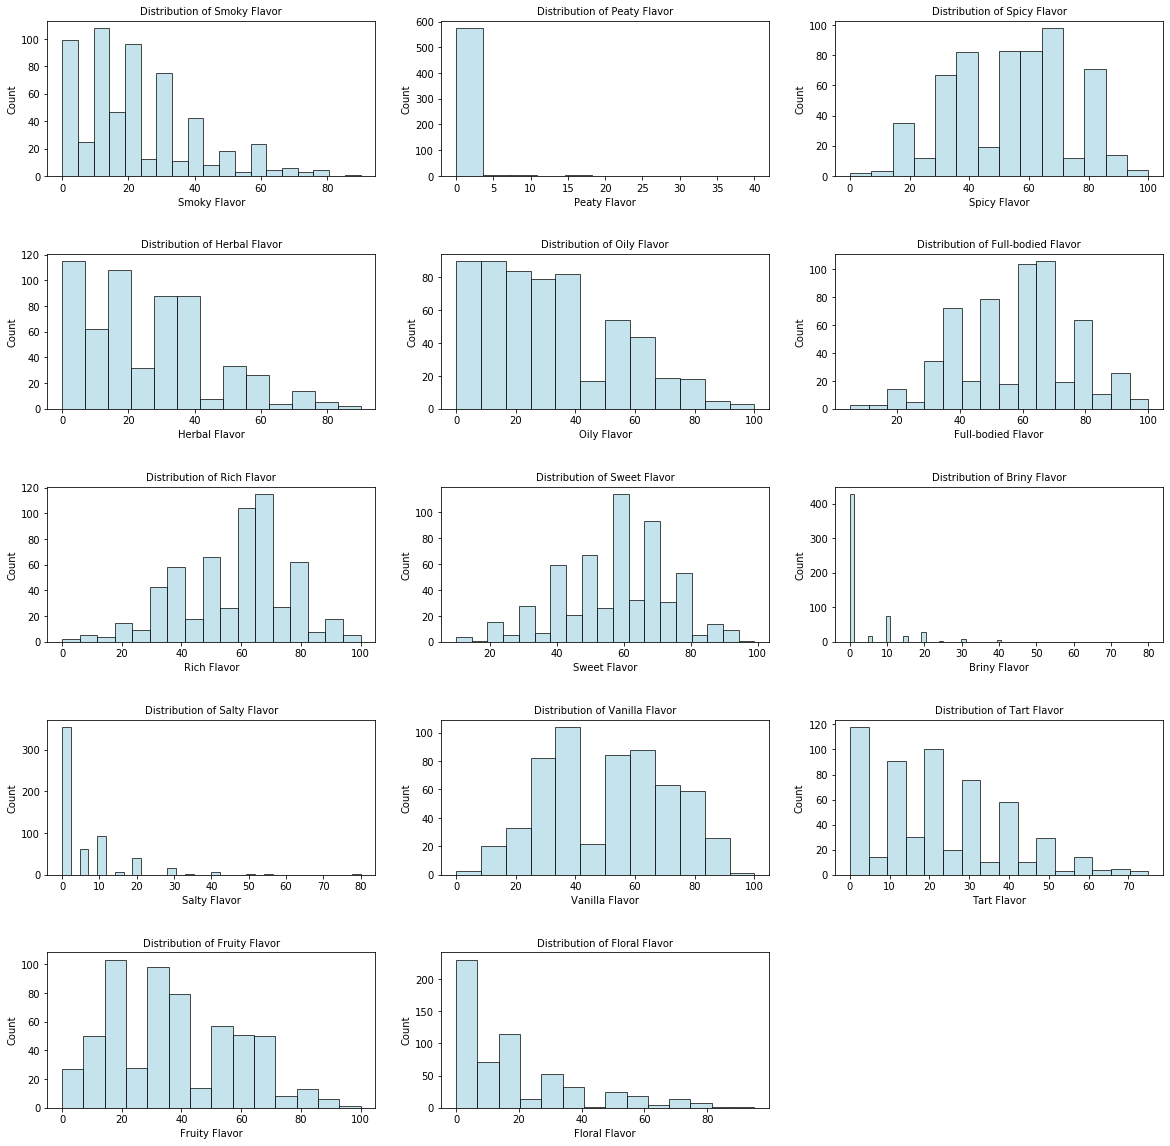

In [49]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
fontsize = 10

flavors = ['Smoky', 'Peaty', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',\
        'Sweet', 'Briny', 'Salty', 'Vanilla', 'Tart', 'Fruity', 'Floral']

# plot histograms
for i, flavor in enumerate(flavors):
    axs[i].hist(df2[flavor], alpha=0.7, color='lightblue', bins='auto', density=False, histtype = 'bar', edgecolor='k')
    axs[i].set_title("Distribution of " + flavor + " Flavor", fontsize=fontsize)
    axs[i].set_xlabel(flavor + " Flavor", fontsize=fontsize)
    axs[i].set_ylabel('Count', fontsize=fontsize)
    
# removes the empty one, since we only have 14 flavors, not 15
axs[14].set_axis_off()

These all seem pretty reasonable, and I'm glad that the values have a good spread. A few flavors are a bit skewed, and these are the ones that we inspected above.

<div class='exercise'>Let's look for any patterns/correlations that may exists between our features. Since some of the above flavors are skewed (e.g., `Salty` is usually 0), we would not be able to discern any meaningful trend, so we can throw this out from our visualization. Otherwise, our graph woud just be a bunch of points overlapping one another at the 0 value.

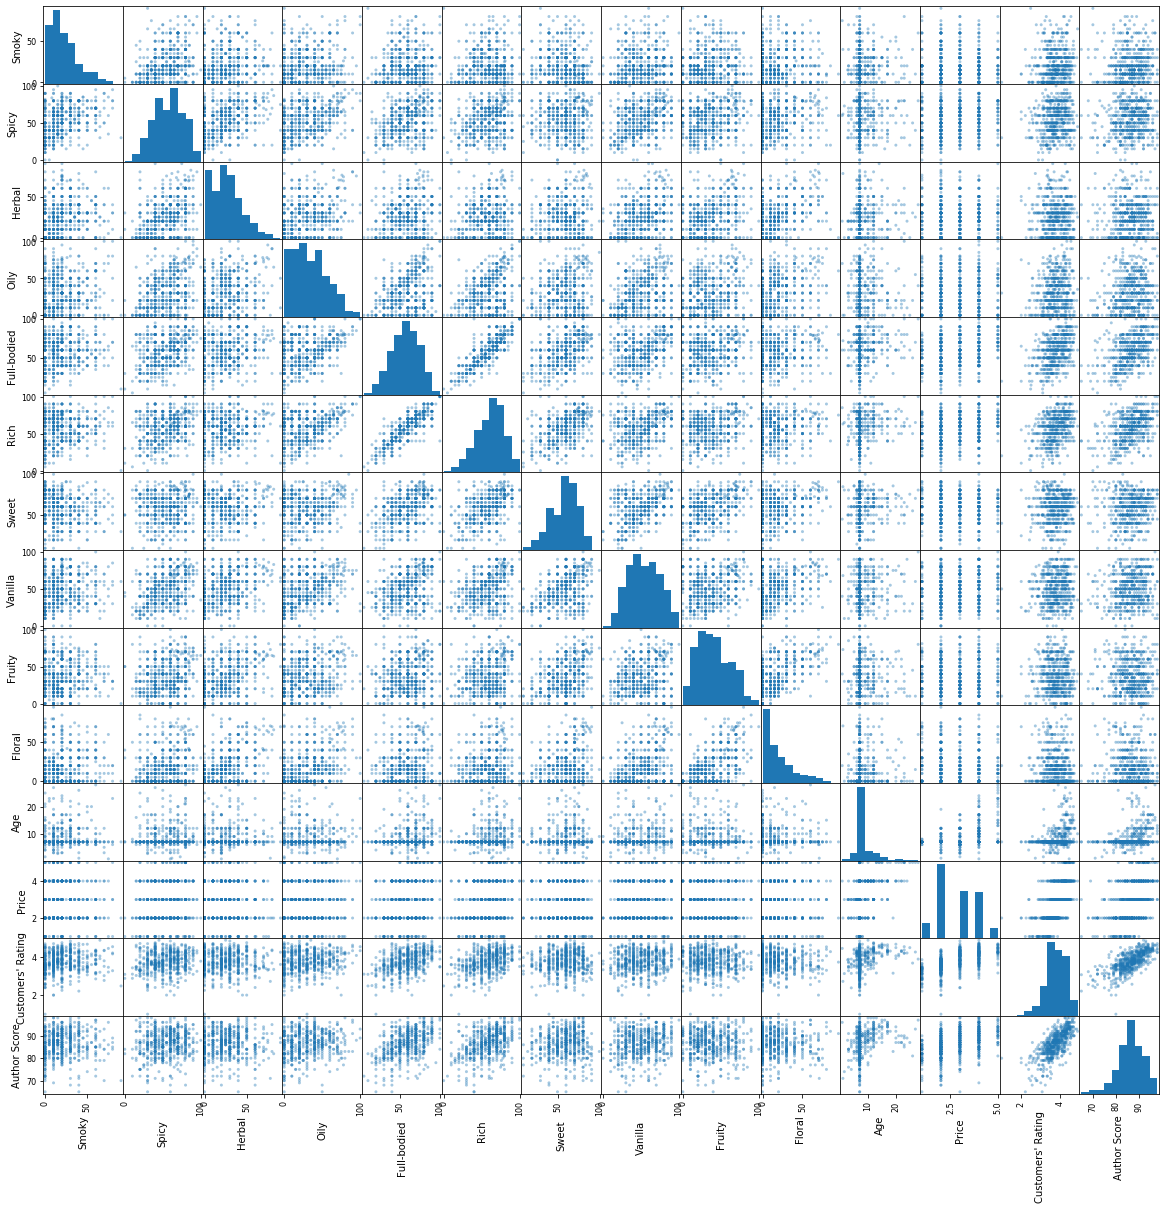

In [50]:
grid_features = ['Smoky', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',\
        'Sweet', 'Vanilla', 'Fruity', 'Floral', \
        'Age', 'Price', 'Customers\' Rating', 'Author Score']

scatter = pd.plotting.scatter_matrix(df2[grid_features], alpha=0.4, figsize=(20,20));
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 90)

We see that:
- `Customer's Rating` is highly correlated with the expert's rating
- The higher the `Price`, the more likely it is to have a high score from both customers and experts
- The higher the `Richness`, the more `Full-bodied` and `Sweet` it tends to be (strong correlations)
- The higher the `Oiliness`, the more likely it is to be `Full-bodied`
- No individual flavor seems correlated with the scores from customers or experts. The closest trend is from `Full-bodied` and `Rich`, as they seem slightly directly correlated with the scores.

This is an indication that predicting the score is not trivially easy; the `Full-bodied` and `Richness` can play some role, but if flavors give any indication, it'll be due to a combination of flavors instead of any one particular flavor.